# Explore Distributed Corpus

The notebook showcases functionalities for exploring the "distributed ngrams", which is a bit slower but doesn't require as much memory compared to loading the complete word count matrix. The querying is parallellized.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [65]:
from tools.ngram_exploration import *
import seaborn as sns
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import jensenshannon
from tqdm import tqdm_notebook
import matplotlib.pylab as plt
sns.set()

# "Deep" Query of Newspaper Collection

In this scenario we obtain finegrained results at level of newspaper-month with the corresponding metadata.

The query_dict allows you to fire a bunch of queries at the same time. The keys are indices/names for each query, the values are a list of terms.

In [162]:
query_dict =  {1:['machine'],
               2:['train','railway'],
               3:['accident','accidents'],
               4:['liberal','liberals'],
               5:['drought','droughts'],}

In [163]:
# initialize the corpus
path = '/Volumes/X9 Pro/ngrams-by-nlp-all/'
corpus = DistributedCorpus(path,n_cores=12)

In [164]:
path = 'data/PolLabelReclassification - label_reclassification.csv'
target_col = 'label_alt'
corpus.simplify_political_labels(path,target_col)

In [165]:
res = corpus.query(query_dict) # query the corpus


In [166]:
len(corpus.vocab_set)

196719

In [170]:
df = corpus.add_context(res) # add context to the query results

In [178]:
timestep = 'year' # define the time step, the temporal unit of analysis, mostly year
facet = 'Leaning'# define the facet i.e. 'COUNTY' | 'Leaning'
# set facet values
# if facet equals COUNTY, possible facet values are ['lancashire','dorsetshire']
facet_values = ['conservative','liberal','independent','neutral']
start_at, end_at = 1830,1920 # set the date range

In [179]:
query_dict_key = 5

In [180]:
# create the time fileter
time_filter = (df.year.between(start_at,end_at))

In [181]:
df.shape, time_filter.sum()

((269179, 54), np.int64(253116))

<Axes: title={'center': "frequency of ['drought', 'droughts']"}, xlabel='year', ylabel='relative_counts_5'>

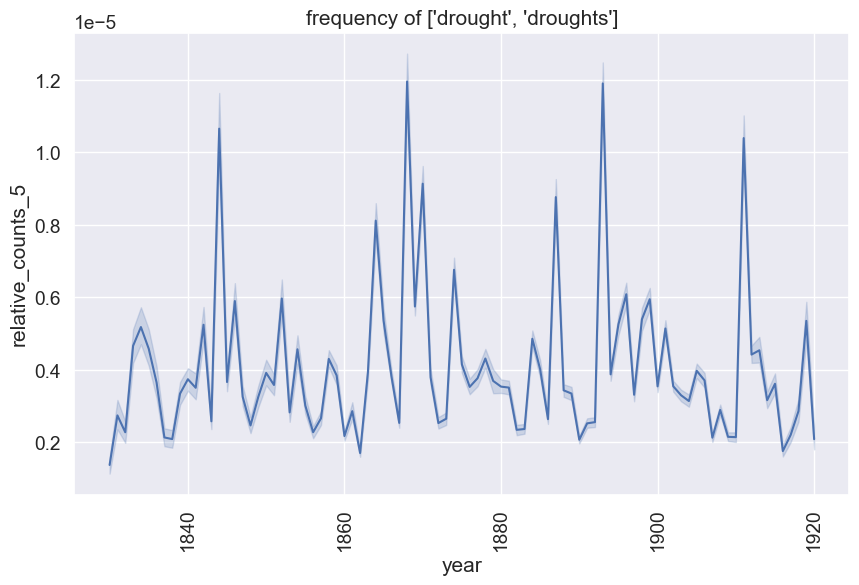

In [182]:
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
plt.title(f'frequency of {str(query_dict[query_dict_key])}')
sns.set(font_scale= 1.25)
sns.lineplot(x=timestep,y=f'relative_counts_{query_dict_key}',data=df[time_filter])

<Axes: title={'center': 'frequency of "[\'drought\', \'droughts\']" by political leaning'}, xlabel='year', ylabel='relative_counts_5'>

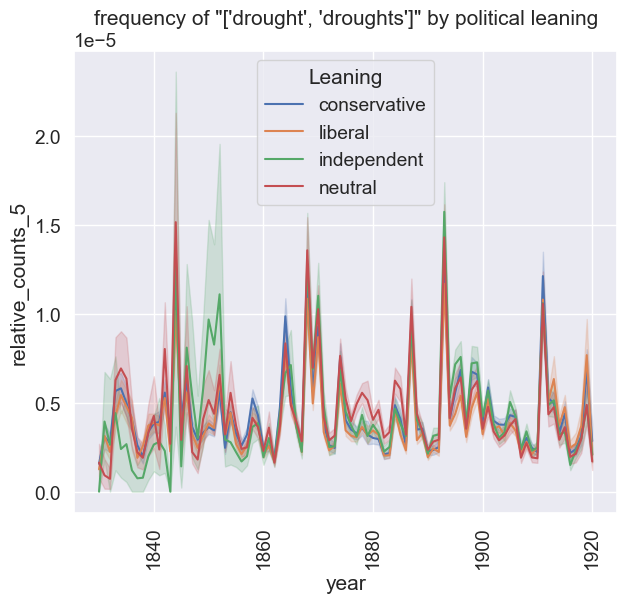

In [183]:
plt.figure(figsize=(7,6))
plt.xticks(rotation=90)
plt.title(f'frequency of "{str(query_dict[query_dict_key])}" by political leaning')
sns.lineplot(x=timestep,y=f'relative_counts_{query_dict_key}',hue=facet,data=df[time_filter],hue_order=facet_values)

<Axes: xlabel='decade'>

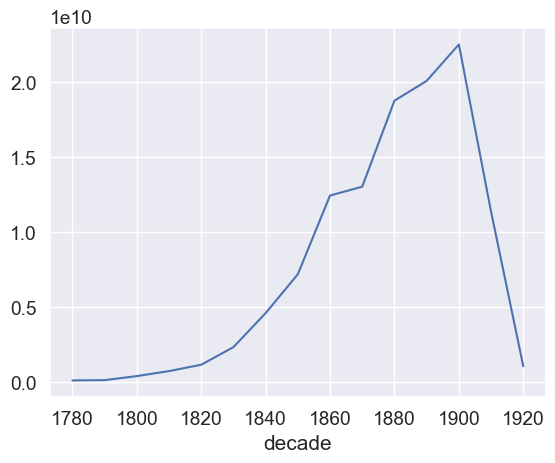

In [177]:
df['decade'] = df['year'].apply(lambda x: str(x)[:3] + '0') # bin the years into decades
df.groupby('decade')['totals'].sum()['1780':'1920'].plot() # count the number of ngrams per decade

## Create and plot time lines

<Axes: xlabel='year'>

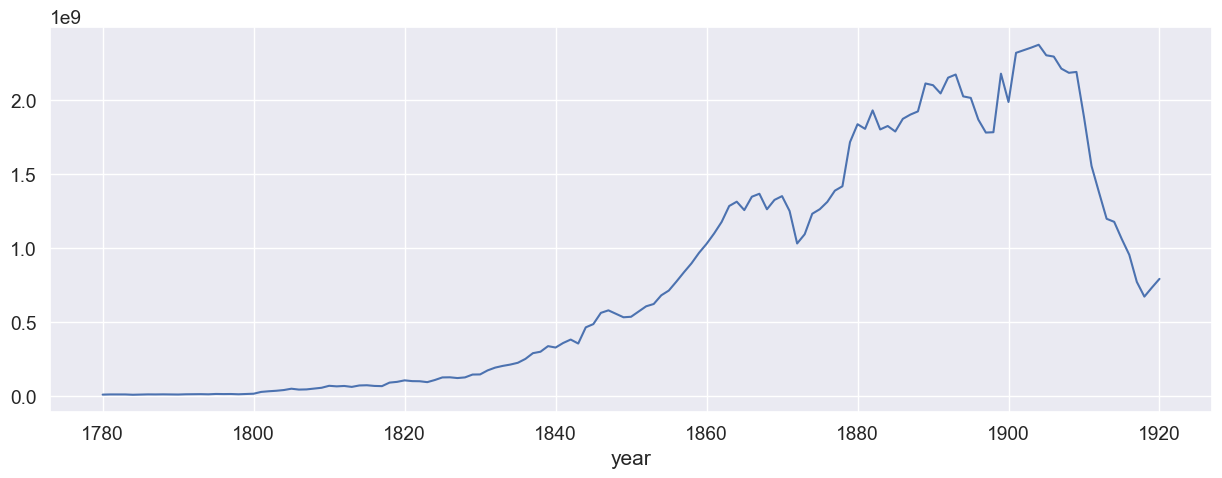

In [160]:
df.groupby('year')['totals'].sum().loc[1780:1920].plot(figsize=(15,5))

<Axes: xlabel='year'>

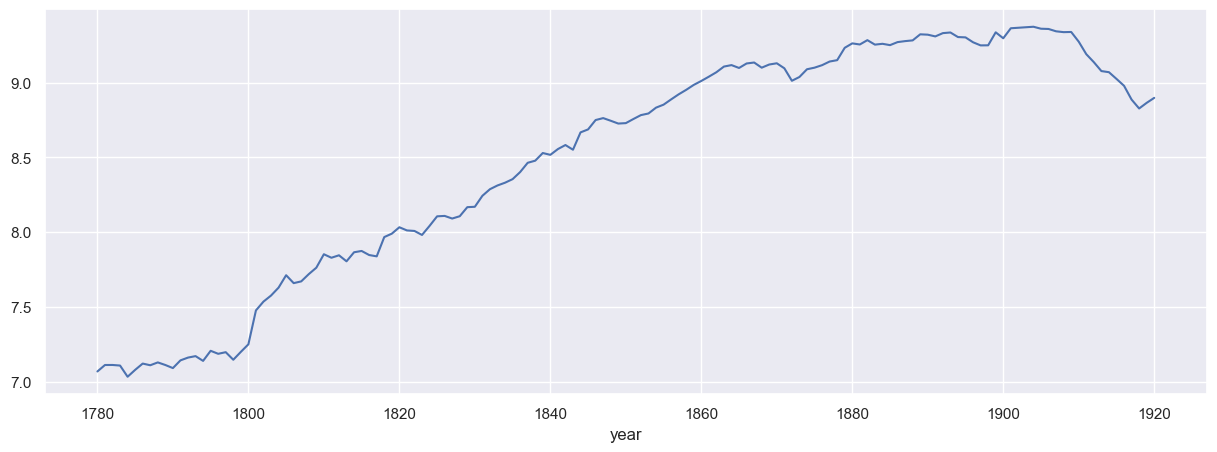

In [26]:
df.groupby('year')['totals'].sum().apply(np.log10).loc[1780:1920].plot(figsize=(15,5))

<Axes: xlabel='month'>

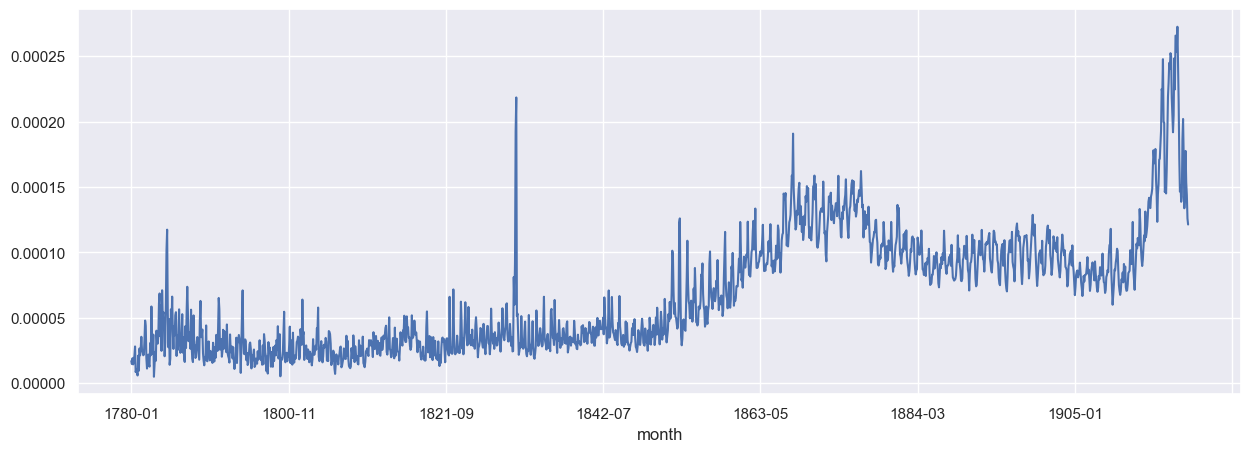

In [27]:
(df.groupby('month')['counts_4'].sum() / df.groupby('month')['totals'].sum())["1780-01":"1920-01"].plot(figsize=(15,5))

<Axes: xlabel='year'>

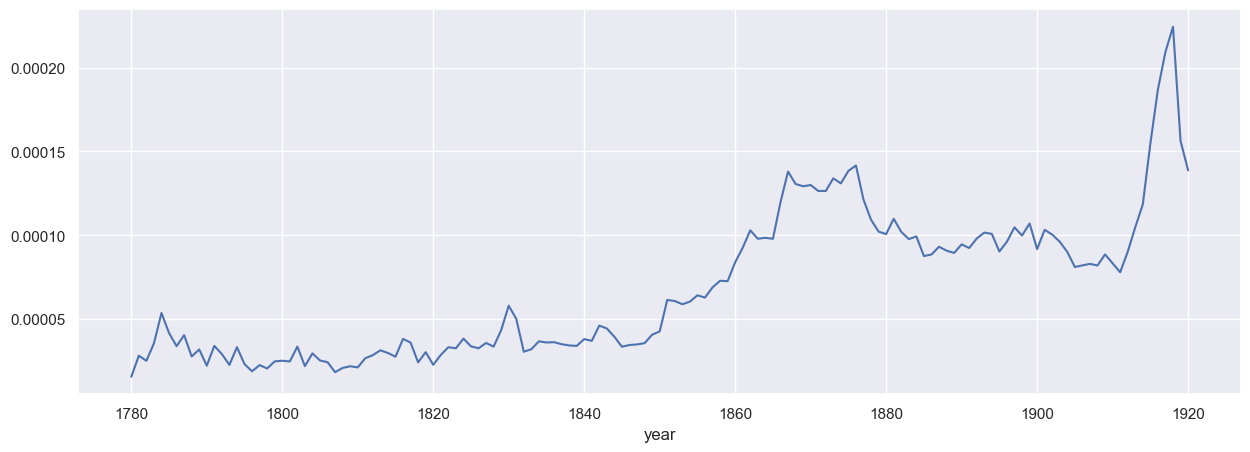

In [28]:
(df.groupby('year')['counts_4'].sum() / df.groupby('year')['totals'].sum()).loc[1780:1920].plot(figsize=(15,5))


# "Light" Query and Divergence Heatmap

In [30]:
corpus = DistributedCorpus(path,n_cores=12)

In [31]:
%time counts,ts = corpus.counts_by_timestep('year')

  0%|          | 0/1204 [00:00<?, ?it/s]

CPU times: user 39.5 s, sys: 38.3 s, total: 1min 17s
Wall time: 2min 41s


In [32]:
matrix_norm = (counts.T / counts.sum(axis=1)).T

## Timeline

CPU times: user 90.6 ms, sys: 30.7 ms, total: 121 ms
Wall time: 125 ms


<Axes: >

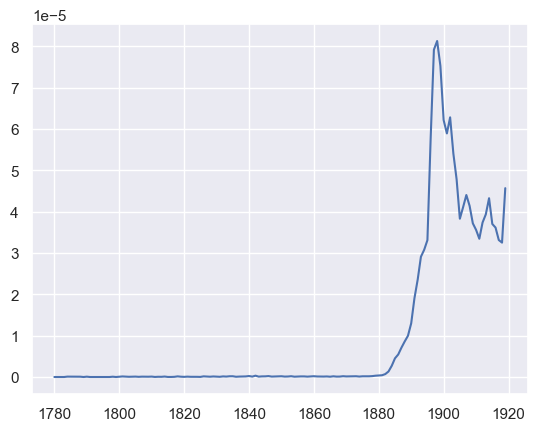

In [33]:
kwList = ['cycling','cycles']
%time pd.Series(matrix_norm[:,[corpus.vocab_mapping[kw] for kw in kwList]].sum(axis=1),index=ts).plot()

## Heatmap

In [34]:
pairdist = pairwise_distances(matrix_norm,metric=jensenshannon)

In [35]:
#labels = sorted(counts_norm.keys())
df_pairdist = pd.DataFrame(pairdist,columns=ts,index=ts)

<Axes: >

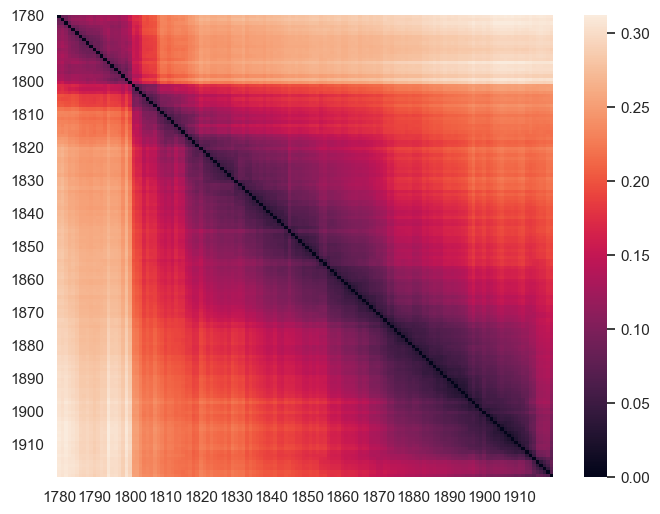

In [36]:
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(df_pairdist,
            xticklabels=10, 
            yticklabels=10)

<Axes: >

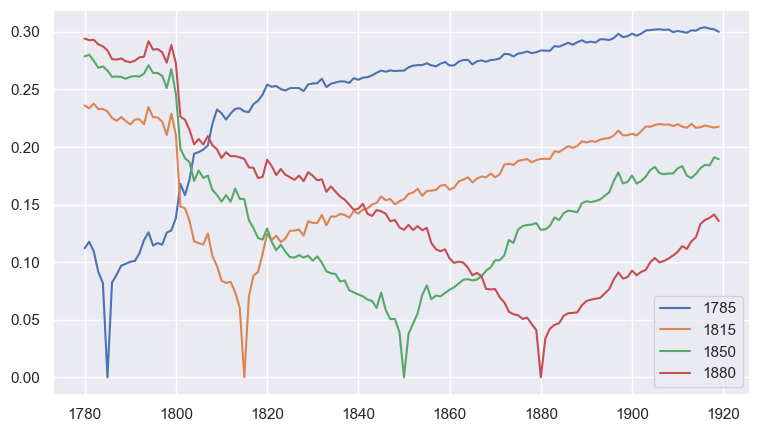

In [37]:
selected_years = [5,35,70,100]

df_temp = pd.DataFrame([pairdist[i] for i in selected_years],
                       index=[ts[i] for i in selected_years],
                       columns=ts).T

sns.set(rc={'figure.figsize':(9,5)})
df_temp.plot()

<Axes: >

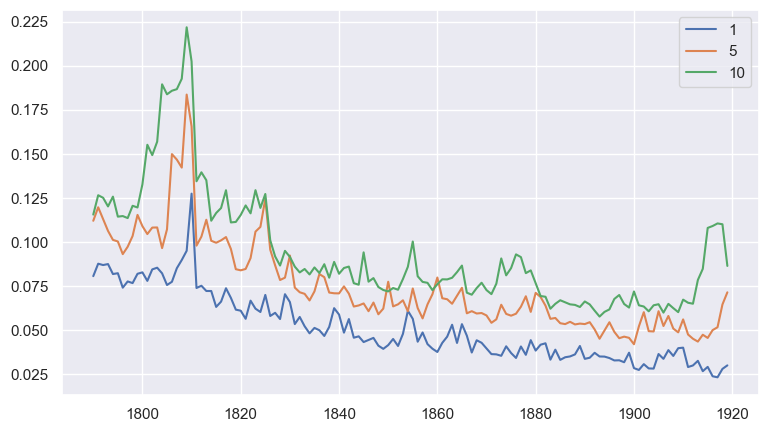

In [38]:
distances = [1,5,10]

df_dist = pd.DataFrame([[pairdist[i,i+d] for i in range(len(pairdist)-distances[-1])] for d in distances],
             index=distances,
                       columns=ts[distances[-1]:]).T
sns.set(rc={'figure.figsize':(9,5)})
df_dist.plot()

# Word contributions by decade

In [ ]:
# TO DO: Apapt to new code

In [ ]:
matrix = np.squeeze([counts[y] for y in sorted(counts.keys())])

In [ ]:
from collections import defaultdict
dec2idx = defaultdict(list)

for i,y in enumerate(range(1780,1920)):
    dec2idx[int(str(y)[:3]+'0')].append(i)

In [ ]:
dec2idx

In [ ]:
partial_kl = lambda p,q : p * np.log(2 * p / (p + q))       

def partial_js(p,q):
    m = (p + q) / 2
    r = p / m
    if r and r != 2.0:
        return m * ( r * np.log2(r) + (2-r) * np.log2(2-r)) / 2
    return m * ((2) * np.log2(2)) / 2

In [ ]:
counts_by_decade = {}
for decade,idx in dec2idx.items():
    ts_counts = matrix[idx].sum(axis=0)
    ts_total = ts_counts.sum()
    counts_by_decade[decade] = (ts_counts / ts_total)

In [ ]:
matrix_decade = np.squeeze([counts_by_decade[y] for y in sorted(counts_by_decade.keys())])

In [ ]:
labels_decade = sorted(counts_by_decade.keys())
pairdist_decade = pairwise_distances(matrix_decade,metric=jensenshannon)
df_pairdist_decade = pd.DataFrame(pairdist_decade,columns=labels_decade,index=labels_decade)

In [ ]:
#df_pairdist_decade.mean().plot()

In [ ]:
sns.set(rc={'figure.figsize':(7,5)})
sns.heatmap(df_pairdist_decade,
            xticklabels=1, 
            yticklabels=1)

In [ ]:
decades = sorted(counts_by_dec.keys())
indices = range(len(counts_by_dec))
dec_bigrams = list(zip(decades[:-1],decades[1:]))
idx_bigrams = list(zip(indices[:-1],indices[1:]));idx_bigrams

In [ ]:
#corpus.vocab_mapping

In [ ]:

results_part = {}
for d1,d2 in tqdm_notebook(idx_bigrams): # compute feature that have string signal for d2
    results_part[(decades[d1],decades[d2])] = {w : partial_js(matrix_decade[d2,i],matrix_decade[d1,i]) for w,i in corpus.vocab_mapping.items()
                                if not np.isnan(partial_js(matrix_decade[d2,i],matrix_decade[d1,i])) and len(w)>2
                       }

In [ ]:
df_contr_contr = pd.DataFrame(
                sorted(results_part[(1900,1910)].items(),key = lambda x : x[1], reverse=True)[:50],
                columns=['w','c'])
sns.set(rc={'figure.figsize':(5,15)})
sns.barplot(y='w',x='c',data=df_contr_contr,color='b')

# Fin.